In [1]:
%%capture
# Import relevant modules

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import math
import random
import numpy as np
import healpy as hp
from scipy.integrate import quad
from scipy.integrate import trapz
from scipy.special import gammaincc
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import chi2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import *
import pandas as pd
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
from probfit import UnbinnedLH, gaussian, Chi2Regression
from NPTFit import create_mask as cm
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import constants_noh as constants
import units

In [2]:
trials = 100
xsec = 1e-24
marr = [100]
channel = 'b'
Nb = 1
conc = "SP"

In [3]:
# Setting basic parameters
nside = 128
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('fermi_data/fermidata_pscmask.npy'), dtype=bool)
exposure=np.array(np.load('fermi_data/fermidata_exposure.npy'))
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = True, inner = 20, outer = 180, custom_mask = pscmask)
#mask = cm.make_mask_total(mask_ring = False, inner = 0, outer = 0)

In [4]:
# Defining some constants
r_s = 199 # scale radius, [kpc]
alpha = 0.678
N_calib = 300. # Number of subhalos with masses 10^8 - 10^10 M_sun
M_MW = 1.1e2 # [1e10 M_s]
mMin_calib = 1e-2 # [1e10 M_s]
mMax_calib = 1 # [1e10 M_s]
mMin = 1e-5*M_MW
mMax = 0.01*M_MW # [1e10 M_s]
c_arr = [37.5153, -1.5093, 1.636 * 10**(-2), 3.66 * 10**(-4), -2.89237 * 10**(-5), 5.32 * 10**(-7)] # constants for SP c-m relation
min_flux =np.log10(1./(np.sum(exposure[~mask])/len(exposure[~mask])))

In [5]:
# Some function
def dNdm_func(m): # Subhalo mass function
    norm = N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9)))
    return norm * (m)**(-1.9)
N_subs = round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) # Total number of subhalos
N_subs = np.random.poisson(N_subs)

rho_s2 = float(N_subs) / quad(lambda x: 4 * np.pi * x**2 * np.exp( -2./alpha * ( (x/r_s)**(alpha) - 1)), 0, constants.r_vir)[0]
def rho_Ein(r): # Einasto density Profile
    return np.exp( (-2./alpha) * ( (r/r_s)**(alpha) - 1))

def c200_SP( M200 ): # Sanchez-Conde-Prada mass-concentration relation
    c200_val = 0
    for i in range(6):
        c200_val += c_arr[i] * ( np.log( M200*1e10*units.h ) )**i
    return c200_val

def c200_S( M200, r ): # Distance dependent m-c relation
    alphaR = 0.286
    C1 = 119.75
    C2 = -85.16
    alpha1 = 0.012
    alpha2 = 0.0026
    return (r/402)**(-alphaR) * ( C1*(M200*1e10)**(-alpha1) + C2*(M200*1e10)**(-alpha2))

def c200( M200, r ):
    M200 = M200*1e-10/units.M_s
    r = r/units.kpc
    if conc == "SP": return c200_SP(M200)
    elif conc == "S": return c200_S(M200, r)
    else: 
        print("Invalid concentration!")
        return np.nan
def myLog(n):
    return np.where( n!=0, np.log10(n), 0);


In [6]:
# Defining arrays necessary for inverse transform
r_arr = np.logspace(0, np.log10(2000), 60500) # radius values to test
m_arr = np.logspace(np.log10(mMin), np.log10(mMax), 80000) # mass values to test
cum_N = np.zeros(len(r_arr)) # CDF
for ir, r in enumerate(r_arr):
    cum_N[ir] = quad(lambda x: 4*np.pi * x**2 * rho_Ein(x), 0, r)[0]
cum_N = cum_N / max(cum_N)
interp_N = np.interp(np.linspace(0,1,N_subs), cum_N, r_arr)

In [7]:
%%capture
# Particle physics factor
dNdLogx_df = pd.read_csv('Data/AtProduction_gammas.dat', delim_whitespace=True)

ebins = [2,20]
PPnoxsec_arr = np.zeros(len(marr))
for mi in range(len(marr)):
    dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(marr[mi])))))[['Log[10,x]',channel]]
    Egamma = np.array(marr[mi]*(10**dNdLogx_ann_df['Log[10,x]']))
    dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
    dNdE_interp = interp1d(Egamma, dNdEgamma)
    if ebins[0] < marr[mi]:
        if ebins[1] < marr[mi]:
            # Whole bin is inside
            PPnoxsec_arr[mi] = 1.0/(8*np.pi*marr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[0], ebins[1])[0];
        else:
            # Bin only partially contained
            PPnoxsec_arr[mi] = 1.0/(8*np.pi*marr[mi]**2)*quad(lambda x: dNdE_interp(x), ebins[0], marr[mi])[0];
PPnoxsec_arr = PPnoxsec_arr

In [8]:
# Integration part of J-Factor
def J_int(M200, r):
    r200 = ( 3 * M200 / (4 * np.pi * 200 * 1.8788e-26*units.h**2*units.Kilogram/units.Meter**3) )**(1./3.) # Units [kpc]
    c = c200(M200, r)
    return M200**2 * c**3/(12*np.pi*r200**3)*(1-1/(1+c)**3.)*(np.log(1+c)-c/(1+c))**(-2)

In [9]:
Omegapix = hp.nside2pixarea(nside)
def r_galactocentric(l, psi_deg):
    return np.sqrt(constants.r0**2. + l**2. - 2.*constants.r0*l*np.cos(np.radians(psi_deg)))

def Einasto_integral_LOS(psi_deg):
    return quad(lambda l: rho_Ein(r_galactocentric(l, psi_deg)), 0., 1000.)[0]

def make_Einasto_template():
    psi_deg = np.arange(0., 180.5, 0.5)
    integrand_Ein = np.vectorize(Einasto_integral_LOS)(psi_deg)
    Einasto_Int = interp1d(psi_deg, integrand_Ein*Omegapix)
    psi_deg_pixels = np.array([np.degrees(np.arccos(np.dot([1.0, 0.0, 0.0], hp.pix2vec(nside, pix)))) for pix in range(npix)])                                                                 
    return Einasto_Int(psi_deg_pixels)

template = np.nan_to_num(make_Einasto_template())
template = 1.2 * template / max(template)
np.save("EinastoTemplate", template)

In [10]:
# Creating a mock dataset, calculating F for all subhalos
def get_fluxes():
    mass_arr = np.array(( m_arr[0]**(-.9) - (m_arr[0]**(-.9) - m_arr[-1]**(-.9))*np.random.rand(N_subs))**(-1/.9)) # Subhalo masses
    rval_arr = np.array(interp_N[np.random.randint(0, N_subs, N_subs)]) # Subhalo radii
    theta_arr = (np.arccos(2*np.random.rand(N_subs)-1)) # Subhalo theta, galactocentric coordinates
    phi_arr = (2*np.pi*np.random.rand(N_subs)) # Subhalo phi, galactocentric coordinates

    coords = (coord.Galactocentric(x=rval_arr*np.cos(phi_arr)*np.sin(theta_arr) * u.kpc,
                                  y=rval_arr*np.sin(phi_arr)*np.sin(theta_arr) * u.kpc,
                                  z=rval_arr*np.cos(theta_arr) * u.kpc, 
                                  galcen_distance=constants.r0*u.kpc)).transform_to(coord.Galactic) # Convert to galactic coordinates
    dA_vals = coords.distance.value # Halo-Earth distances
    b_vals = np.radians(coords.b.value) # Subhalo b values
    l_vals = np.radians(coords.l.value) # Subhalo l values
    pixels = hp.ang2pix(nside, np.pi/2.-b_vals, l_vals) # Subhalo pixel numbers

    # Calculate J-factors, convert to correct units
    subhalos_J = J_int(mass_arr*1e10*units.M_s, rval_arr*units.kpc)/(np.array(dA_vals)*units.kpc)**2
    subhalos_J = np.array(subhalos_J)/ (units.GeV**2/units.Centimeter**5) #* (1e10*units.M_s)**2 * (units.kpc)**(-3)

    J_hist = np.histogram(np.log10(subhalos_J), bins=np.linspace(12,20,100))
    subhalos_flux2 = xsec * PPnoxsec_arr[0] * subhalos_J[~mask[pixels]]
    hist = np.histogram(subhalos_flux2, bins=np.logspace(-15, -6, 8*8))
    return np.array(hist[0]), mass_arr, rval_arr, theta_arr, phi_arr, dA_vals, b_vals, l_vals, pixels, subhalos_J # Save fluxes

In [11]:
# Run get_fluxes for trials number of mock datasets
F_arr = []
for trial in range(trials):
    F_arr.append(get_fluxes()[0])

In [12]:
bins = np.logspace(-15, -6, 8*8)
min_flux_ind = np.argmin(np.abs(bins - 10.**(min_flux)))
bins = bins[min_flux_ind:]

F_arr2 = (np.array(F_arr)[:,min_flux_ind:]).astype(np.float64)
for i in range(len(F_arr2)):
    np.place(F_arr2[i], F_arr2[i]==0, 1e-50)
F_ave = np.median(F_arr2, axis=0)
max_flux = np.log10(bins[np.argmax(F_ave < 1e-20)])
area_rat = (len(mask[~mask]))/len(mask)
dF = np.diff(bins)
dN = np.array(F_ave)/(4*np.pi*(180/np.pi)**2*area_rat)
dN_0 = dN.copy()
np.place(dN_0, dN_0 < 1./(4*np.pi*(180/np.pi)**2*area_rat), 0.)
F = (np.array(bins)[:-1]+np.array(bins)[1:])/2.

In [13]:
err_dn = F**2*dN/dF - chi2.ppf(.32/2, 2*F_ave)/2. * F**2/dF /(4*np.pi*(180/np.pi)**2*area_rat)
err_up = chi2.ppf(1-.32/2, 2*(1+F_ave))/2. * F**2/dF /(4*np.pi*(180/np.pi)**2*area_rat) - F**2*dN/dF

err_std_up = np.std(F_arr2, axis=0)* F**2/dF /(4*np.pi*(180/np.pi)**2*area_rat)
err_std_dn = np.std(F_arr2, axis=0)* F**2/dF /(4*np.pi*(180/np.pi)**2*area_rat)
for iF, Fv in enumerate(F_ave):
    if trials == 1 or Fv < 1: 
        err_std_up[iF] = err_up[iF]
        err_std_dn[iF] = err_dn[iF]
err = np.array([np.nan_to_num(err_std_dn), np.nan_to_num(err_std_up)])
upper_68 = myLog(np.percentile(F_arr2, axis=0, q=16)* F**2/dF /(4*np.pi*(180/np.pi)**2*area_rat))
lower_68 = myLog(np.percentile(F_arr2, axis=0, q=84)* F**2/dF /(4*np.pi*(180/np.pi)**2*area_rat))

In [14]:
def simple_fit(F, A, *args):
    results = []
    if (len(args) - 1) % 2 != 0: return np.nan
    N_b = int((len(args) - 1) / 2)
    n = np.array(args[:N_b+1])
    Fb = np.array(args[N_b+1:])
    for i in reversed(range(len(Fb)-1)):
        Fb[i] = Fb[i+1] - np.abs(Fb[i])
    Fbv = np.array(Fb.copy())
    Fbv = np.concatenate(([Fbv[0]], Fbv))
    Fb = np.concatenate(([-np.inf], Fb, [np.inf]))

    
    if not hasattr(F, "__len__"): F = [F]
    for Fv in np.array(F):
        place = np.where(np.logical_and(Fv < Fb[1:], Fv >= Fb[:-1]) != 0)[0][0]
        if place == 0: results.append(A - n[0]*(Fv - Fbv[0]))
        elif place == 1: results.append(A - n[1]*(Fv - Fbv[1]))
        else: results.append(A - (n[place]*(Fv - Fbv[place]) - sum(n[i-1]*(Fbv[i]-Fbv[i-1]) for i in range(1, place+1))))
    return results

def loglike(x, y, f, *args):
    y = np.array(y)
    x = np.array(x)
    return -0.5*sum((np.logical_and(min_flux < np.array(x), np.array(x) < max_flux).astype(np.float64))*(y-f(x, *args))**2 for x, y in zip(x, y))

argument_list = "A"
options = "A = -14, limit_A=(-16,1), error_A=1"
for i in range(1, Nb+1): 
    argument_list = argument_list + ", n"+str(i)
    options += ", n"+str(i)+"=-0.06, limit_n"+str(i)+"=(-10.,10.), error_n"+str(i)+"=1e-3"
argument_list += ", n"+str(Nb+1)
options += ", n"+str(Nb+1)+"=10, fix_n"+str(Nb+1)+"=True"
delta_flux = max_flux - min_flux
print(delta_flux)
for i in range(1, Nb):
    argument_list += ", Fb"+str(i)
    options += ", Fb"+str(i)+"="+str(min_flux)+", limit_Fb"+str(i)+"=(0, "+str(delta_flux)+"), error_Fb"+str(i)+"=.1"
argument_list += ", Fb"+str(Nb)
options += ", Fb"+str(Nb)+"="+str(max_flux)+", fix_Fb"+str(Nb)+"=True"
options += ""
exec("minuit = iminuit.Minuit(lambda %s: -loglike(myLog(F), myLog(F**2*dN/dF), simple_fit, %s), %s)" % (argument_list, argument_list, options));
minuit.migrad();
F_test = np.logspace(min_flux-1, max_flux+1, 8*8)
results = []
for val in minuit.values:
    results.append(minuit.values[val])

1.1018458576902113


/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: InitialParamWarning: errordef is not given. Default to 1.
  """Entry point for launching an IPython kernel.


FCN = 0.021366929421379407 
 TOTAL NCALL = 30 
 NCALLS = 30 
 
 
 EDM = 6.3666433289751315e-09 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,A,-13.9346,0.995033,0,0,-16.0,1.0,
2,n1,-0.01592,1.52222,0,0,-10.0,10.0,
3,n2,10,1,0,0,,,FIXED
4,Fb1,-9.71429,1,0,0,,,FIXED


/home/jean/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10


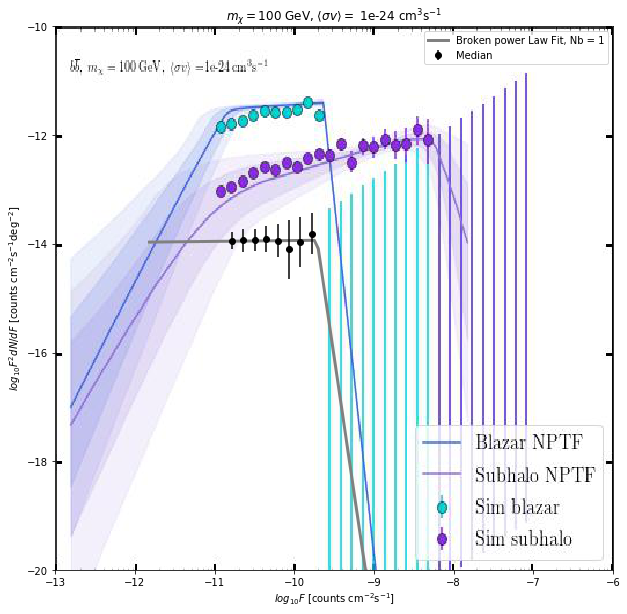

In [15]:
plt.figure(figsize=(10,10))
img = plt.imread("1e-24im.jpg")
plt.imshow(img, extent=[-13,-6,-20,-10], aspect='auto')
plt.errorbar(myLog(F), myLog(F**2 * dN_0/dF), yerr = 1/np.log(10) * err/(F**2 * dN/dF), fmt='o', c="black", zorder=10, label="Median")
plt.plot(myLog(F_test), simple_fit(myLog(F_test), *results), zorder=5, linewidth=3, c="grey", label="Broken power Law Fit, Nb = " +str(Nb))
plt.ylim(-20, -10)
plt.xlim(-13, -6)
plt.title("$m_{\chi} = 100$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
plt.ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
plt.xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
plt.legend()
plt.show()
plt.close()